# Intro to Timeseries Forecasting for Building Experts

Welcome back my little chickadees 🐣. I hope you've been vibing 😎 since the last time I perpetuated our para-social relationship.

Let's jump into what this notebook is about: using Facebook's Prophet model for timeseries forecasting -- in this case, forecasting chilled 🤙 water supply (CHWS) flow.

For those not in the know, chilled water is supplied to cooling systems, i.e. HVAC devices like air handling units and fan coil units, to manage temperature. So, measuring the flow of chilled water (via gallons per minute, in this case) can help quantify the amount of effort being put into cooling a building or a specific building zone. For this first half, we will focus on feature selection for the model, and the second half will build the model itself.

For Part 1, we’ll focus on feature selection for the model, i.e. identifying and selecting key, influential variables. In Part 2, we’ll build the Prophet model itself. This post is going to be useful to building experts (engineers, data analysts, data scientists) who want to know more about sensors and equipment over time.

This first half is pretty non-technical, so even if you don't think you'll be trying to build machine learning models, we'll show some nice basics of data exploration and comparing variables, so it will be accessible and interesting to a wider audience. Part 2 is where things get a bit headier in building out the model.

### Before we Start our Journey

We had a mildly nontradish usage of forecasting to impute missing data in the [last tutorial](https://medium.com/onboard-blog/timeseries-cleaning-and-imputation-a96ab7e45eb7), but here the forecasting is center stage, so I can show you a more typical workflow and use case. In the first half, I'll show a common workflow for feature selection: the exploration of potential features driving this consumption. In the second half (the somewhat more technical part) will involve developing another forecasting model using the feature we chose from the first half.

We rate Part 1 of this tutorial a 2/ 5 difficulty. Basic knowledge of statistics would be helpful, but not strictly necessary. Otherwise, there is no complicated math in this section. If you frequently analyze timeseries data from buildings/equipment this is for you!

### The Onboard API

Don't forget: this is going to use our API and Python client API wrapper package. To learn more about it -- how to use it, how to set it up -- you can check out [our API client docs](https://onboard-api-wrappers-documentation.readthedocs.io/en/latest/index.html). I'll once again only be using our sandbox buildings, which are accessible to anyone on our platform to mess around with and learn from. It's all anonymized data from real buildings in our system, which is super cool. If you want to try it out, [go here](onboarddata.io/sandbox) and request access to get on our platform.

Once again, in this first post I'll explore possible features that may be driving chilled 🧘 water supply flow, and choose one to work with in the second post, when we build the model. If you want to follow along interactively, check out the [colab notebook](https://colab.research.google.com/github/onboard-data/notebooks/blob/dev/05_Forecasting_part_1.ipynb).


## Getting the Data

Before we can get to feature spelunking, as always, let's start off with the boilerplate: loading the API wrapper and querying and cleaning the data. First, we import the client and pandas, and connect to the API.

In [2]:
import numpy as np
import pandas as pd
from onboard.client import OnboardClient
try: # for this you can either create a key.py file with one line: api_key = 'your api key here'
    from key import api_key
except ImportError: # or you can just input your api key when you get the prompt
    api_key = input('My dude, kindly enter your api_key')

client = OnboardClient(api_key=api_key)

### Select Sensors and Get Metadata

For this, we're going to look at chilled 🥶 water flow related to both time-based features and our other sensor, outside temperature. We pre-vetted these sensors as ones of interest for this project, so we won't spend much time exploring buildings for relevant points (terminology note: remember, we mostly use the terms "point" and "sensor" as synonyms -- these are the building entities that supply actual timeseries data). Note that this example comes from a real use-case from one of our clients, so you know this isn't just some randomly fabricated example.

So, first we need to gather those two sensors: chilled ✌️️water supply flow and outside air temp (ok, I swear that's my last emoji. I don't wanna get annoying. But trust me when I say I could do this all day).

In [17]:
import pandas as pd
from onboard.client.models import PointSelector

# buildings in the portfolio
building_df = pd.json_normalize(client.get_all_buildings())

# generate a query for our two points
query = PointSelector()
query.point_ids = [518876, 518877] # these are points in the Laboratory
selection = client.select_points(query)

# query and merge metadata from points, equipment, and buildings:

# point data
sensor_metadata = client.get_points_by_ids(selection['points'])
sensor_metadata_df = pd.DataFrame(sensor_metadata)

# equipment data
equip_metadata = client.get_equipment_by_ids(selection['equipment'])
equip_metadata_df = pd.DataFrame(equip_metadata)

# join sensor and equip and building meta
df = pd.merge(
    sensor_metadata_df,
    equip_metadata_df.drop(
        columns=['building_id']).rename(
        columns={"id": "equip_id", "equip_id": "equip_name"}),
    left_on='equip_id', right_on='equip_id', how='left').merge(
    building_df[['id', 'name', 'address']].rename(
        columns={"id": "building_id", "name": "building_name"}),
    left_on='building_id', right_on='building_id', how='left'
)

display_cols = ['id','building_name','equip_name', 'name', 'type',]
bldg_df = df[display_cols + ['value', 'units']]
bldg_df

,id,building_name,equip_name,name,type,value,units
0,518876,Laboratory,meter-CHW Flow,chw_gpm_avg_2,Chilled Water Supply Flow,1.79,None
1,518877,Laboratory,Site-Sensor,building_oat_9,Outside Air Temperature,46.90,None


### Query Telemetry Data

Now that we have the sensors, let's get a (semi-randomly-chosen) set duration of timeseries data to consider.

In [18]:
from onboard.client.models import TimeseriesQuery, PointData
from onboard.client.dataframes import points_df_from_streaming_timeseries

# look at data from the last week of July / beginning of August
start_stamp = "2022-07-18T00:00:00Z"
end_stamp = "2022-08-7T00:00:00Z"

# query the server
point_ids = bldg_df.id.to_list()
timeseries_query = TimeseriesQuery(point_ids=point_ids, start=start_stamp , end=end_stamp)
sensor_data = points_df_from_streaming_timeseries(client.stream_point_timeseries(timeseries_query))
sensor_data.head() # always good to sneak a peak at what the data looks like

,timestamp,518876,518877
0,2022-07-18T00:00:10Z,2.6,NaN
1,2022-07-18T00:00:12Z,NaN,70.199997
2,2022-07-18T00:01:22Z,1.8,70.199997
3,2022-07-18T00:02:22Z,NaN,70.199997
4,2022-07-18T00:02:23Z,1.8,NaN


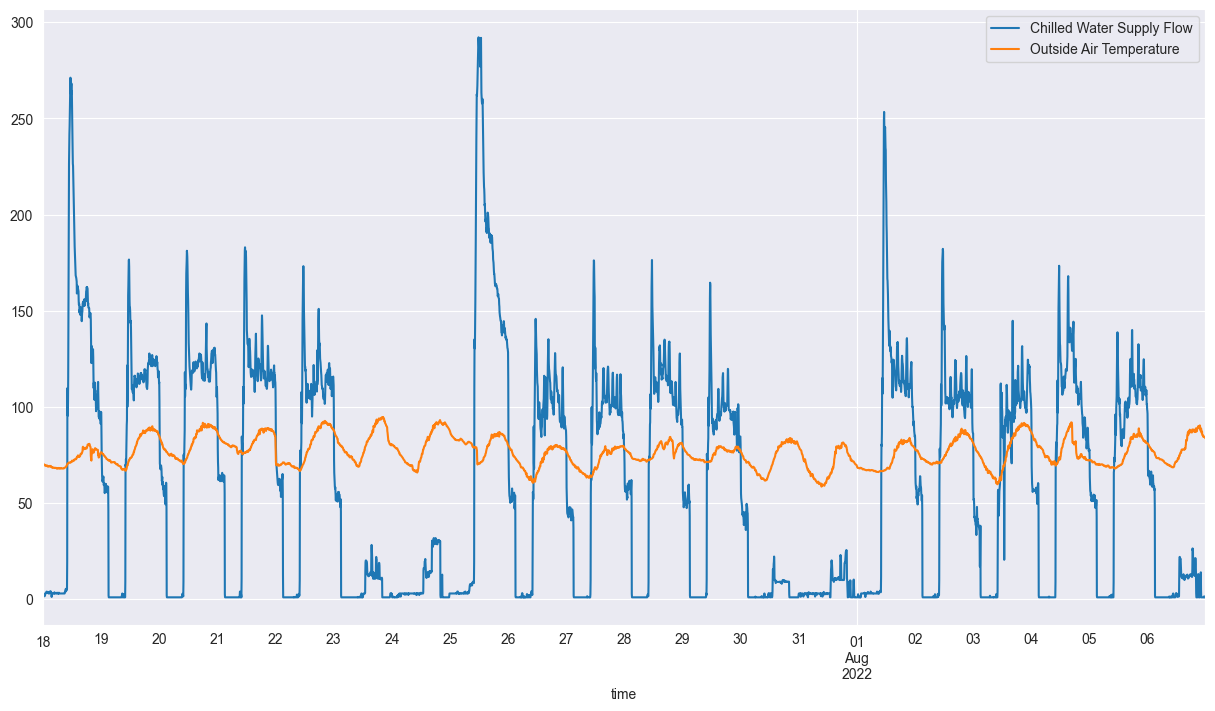

In [20]:
# clean the data
sensor_data.index = pd.to_datetime(sensor_data.timestamp)
sensor_data.index.name = 'time'
five_min_data = sensor_data.resample('5T').mean(numeric_only=True) # resample to consistent 5-min interval
five_min_data = five_min_data.interpolate(limit=12)  # allow up to 1-hour of interpolation

# visualize
names = bldg_df[bldg_df.id.isin(point_ids)][['id','type']] # get point names for nicer legend display
names_dict = {k:v for (k,v) in zip(names['id'], names['type'])}

five_min_data = five_min_data.rename(columns=names_dict)
p = five_min_data.plot(figsize=(15, 8))

Now that we have a visualization of the two sensors, let's dive into the first stage of feature selection: basic hypothesizing.

## Feature Exploration and Selection

<img src="https://media3.giphy.com/media/CBd6lbEDEHdcouLkh4/giphy.gif?cid=790b76115ec5f444eb88502764c1044cb7eb4c40b674c53d&rid=giphy.gif" />

Looking at the two sensor traces as initial exploratory data analysis gives plenty of ideas for where to go from here to see what's driving CHWS. Two that we can guess at from here are exterior temperature/weather, and time. Outside temperature just makes logical sense: usually we would expect as the temperature outside increases, we would need to do more work to cool a building. Looking at the graph, we definitely do see that outside temperature (the yellow trace) has similar seasonality (regular periodic variations) as the chilled water supply (blue trace), but it's not yet clear how strongly they're correlated otherwise. The more likely feature, though, is probably going to be time-based: check out those major dips in CHW supply for two days at a time every seven days. Wanna guess what those are? Shyeah, weekends my dude. There's some other ways our CHWS changes with time, but we'll talk about that in a second.



### Time-based Features

So, to start broadly, we can agree there seems to be a relationship between time and chilled water consumption, but it's definitely not completely straightforward. Let's start with that first trend we tentatively identified, weekdays vs weekends. Here we're going to make use of some nice aspects of Python's datetime object to encode time periods of interest based on our timestamp index.

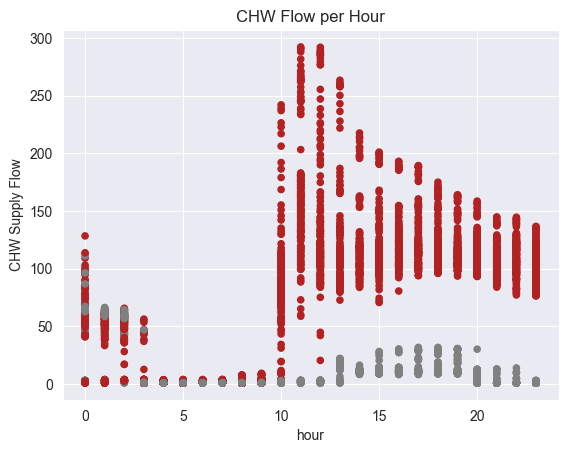

In [71]:
def get_workweek(df):
    if df['weekday'] in [0, 1, 2, 3, 4]:
        return 'week'
    else:
        return 'weekend'

# day type feature coding
five_min_data['hour'] = five_min_data.index.hour
five_min_data['weekday'] = five_min_data.index.weekday
five_min_data['workweek'] = five_min_data.apply(get_workweek, axis=1)

cmap = {'week': 'firebrick', 'weekend': 'gray'} # plot flow per hour, color by weekday vs weekend

p = five_min_data.plot(x='hour',
                   y='Chilled Water Supply Flow',
                   ylabel='CHW Supply Flow',
                   kind='scatter',
                   title='CHW Flow per Hour',
                   c=[cmap.get(c, 'black') for c in five_min_data.workweek])

Here we refined our EDA a bit, collapsing across days and categorizing by our new tentative feature, business operational days (weekdays, red) vs. ~party~ business non-op days (weekends, gray).

Immediately we see a drastic difference in CHW supply between weekend and weekday, as well as differences within a single day, on an hourly basis. This gives us an idea that time does seem to be related to th chilled water supply flow, but this new viz suggests it's not *just* on a per-day scale. Comparing the two visualizations we made so far, we can also surmise that operational vs. non-op *time of day* is related. So let's make a more specific feature, that we'll call "operation", which accounts for both operational days of the week, as well as hours of the day (where the hours are just based on inspection of the graph above).

We'll do some quick categorical encoding to mark operational times -- 1 is operational (work week days, M-F, 10am-midnight), 0 is non-operational (all other times).

In [77]:
def get_opp_status(df):

    if (df['workweek'] == 'week') & ((df['hour'] >= 10) | (df['hour'] == 0)):
        return 1
    else:
        return 0

five_min_data['operation'] = five_min_data.apply(get_opp_status, axis=1)

### Temperature-based Features

Now that we developed a pretty nice time-based feature, let's visualize CHWS against it *and* our other candidate feature, outside air temp. This time, operational time is red, non-op time is gray.

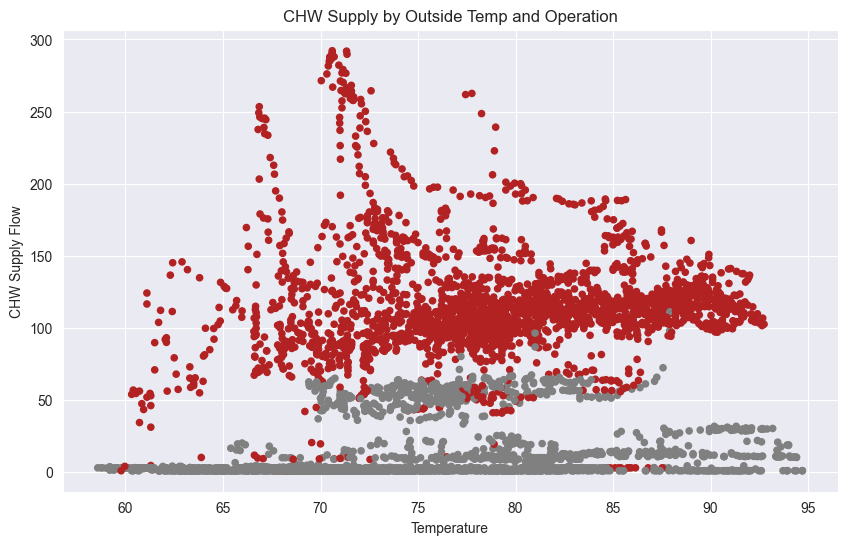

In [83]:
import matplotlib.pyplot as plt

# plot CHW Flow per Deg F. exterior temperature
cmap = {1: 'firebrick', 0: 'gray'}
p = five_min_data.plot(x='Outside Air Temperature', xlabel='Temperature',
                   y='Chilled Water Supply Flow', ylabel='CHW Supply Flow',
                   kind='scatter',
                   title = 'CHW Supply by Outside Temp and Operation',
                   c=[cmap.get(c, 'black') for c in five_min_data.operation],
                   figsize=(10, 6))

Interestingly, this graph shows a general trend between CHWS (y axis) and outside temp (x axis), but perhaps not as strong as we would have thought. On the other hand, this graph still shows a very clear relationship between our new feature, "operation" (gray vs. red dot color), and CHW supply. We can quantify those relationships a bit more clearly using some super easy stats.

#### Stats-Based Comparison

While we've continually seen that our time-based feature ("operation") seems to have the stronger relationship with CHWS flow, we can do one more quick check to confirm that, by using some simple stats. We'll just look at the correlation coefficient between the pairs of variables. It ranges between +1 and -1, where +/- 1 is a perfect linear relationship, where every time one value goes up, the other goes up/down an equal amount. 0 indicates no relationship, or maximal disagreement, between the two variables.

In [81]:
five_min_data[['operation', 'Chilled Water Supply Flow']].corr()

,operation,Chilled Water Supply Flow
operation,1.000000,0.866544
Chilled Water Supply Flow,0.866544,1.000000


In [14]:
five_min_data[['Outside Air Temperature', 'Chilled Water Supply Flow']].corr()

,Outside Air Temperature,Chilled Water Supply Flow
Outside Air Temperature,1.000000,0.337473
Chilled Water Supply Flow,0.337473,1.000000


So, a correlation coefficient of 0.86 is a pretty strong relationship, whereas 0.33 is rather weak. Once again, all signs seem to point to operational hours as having a stronger relationship with chilled water consumption than the outside air temperature. Given that, we will plan to incorporate "operation" into our forecasting model in the next post, and use the model to look both at outlier areas of consumption and future forecasting.

## Conclusion

For this post we spent some time finding useful features to help predict some timeseries data, so we can build a Prophet model to forecast and find outliers. We found chilled water supply showed a strong relationship with operation times, and not so much of a relationship with outside air temp. We'll use this knowledge in the next post to build a forecast model.

<img src="https://media4.giphy.com/media/h5AHEcNMhn7u8/giphy.gif?cid=790b7611a895027d50ea760f4c67a7c47d4b679ff01df210&rid=giphy.gif&ct=g" />